Generando problemas de suma de subconjuntos

In [ ]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time

## Crear Problemas

In [ ]:
class Problem:
  def __init__(self, v_sack, obj_sum, max_evals):
    self.v_sack = v_sack
    # self.v_sol = v_sol
    # self.obj_sum = np.dot(v_sack, v_sol)
    self.obj_sum = obj_sum
    self.n_evals = 0
    self.best_fitness = None
    self.best_sol = None
    self.max_evals = max_evals

  def evaluation(self, v_sol):
    if self.n_evals >= self.max_evals:
      raise Exception('Max evals reached')
    fitness_with_sign = self.obj_sum - np.dot(self.v_sack, v_sol)
    fitness = abs(fitness_with_sign)
    if fitness_with_sign == fitness:
      sign_fitness = 1
    else:
      sign_fitness = -1
    if self.best_fitness is None or fitness < self.best_fitness:
      self.best_fitness = fitness
      self.best_sol = v_sol
    self.n_evals += 1
    return [fitness,sign_fitness]

  def create_new_try_clone(self):
    return Problem(self.v_sack, self.obj_sum, self.max_evals)

  def clone(self):
    problem = Problem(self.v_sack, self.obj_sum, self.max_evals)
    problem.n_evals = self.n_evals
    problem.best_fitness = self.best_fitness
    problem.best_sol = self.best_sol
    return problem

In [ ]:
def createEasyProblem(len_vector,initial_range):
  v_sack = np.zeros(len_vector, dtype='object')

  for i in range(len_vector):
    rmin = (2**(i)-1) * initial_range + 1
    rmax = (2**(i)) * initial_range
    r = random.randint(rmin,rmax)
    v_sack[i] = r

  return v_sack

def isEasy(v_sack):
  sum = 0
  for i in range(len(V)):
    if sum >= V[i]:
      return False
    sum += V[i]
  return True

def turnDificult(v_sack,p,m):
  n = len(v_sack)
  new_sack = np.zeros(n, dtype='object')
  for i in range(n):
    new_sack[i] = p*v_sack[i] % m
  return new_sack

def turnEasy(v_sack,p,m):
  n = len(v_sack)
  new_sack = np.zeros(n, dtype='object')
  p = pow(p,-1,m)
  for i in range(n):
    new_sack[i] = p*v_sack[i] % m
  return new_sack

def generateCriptoSistem(len_vector,initial_range):
  m = random.randint((2**(len_vector)-1) * initial_range + 1,2**(len_vector) * initial_range)
  p = random.randint(2,m-1)
  d = math.gcd(m,p)
  if d != 1:
    p = p//d
  private_key = [p,m]
  v_sack = createEasyProblem(len_vector,initial_range)
  public_key = turnDificult(v_sack,p,m)

  return(public_key,private_key)

def generateProblem(len_vector,initial_range,max_evals):
  [public_key,private_key] = generateCriptoSistem(len_vector,initial_range)
  obj_sum = np.dot(np.array([random.randint(0,1) for i in range(len_vector)]),public_key)
  problem = Problem(public_key,obj_sum,max_evals)
  return problem


## Algoritmos

In [ ]:
class RandomAlgorithm:
  def __init__(self):
    self.name = "Random algorithm"

  def solve(self, problem):
    for i in range(problem.max_evals):
      sol = [random.randint(0,1) for i in range(len(problem.v_sack))]
      problem.evaluation(sol)
      #print(f'Eval {i}: fitness: {problem.best_fitness}')
      if problem.best_fitness == 0:
        break

class ExhaustiveAlgorithm:
  def __init__(self):
    self.name = "Algoritmo Exhaustivo"

  def solve(self, problem):
    problem_length = len(problem.v_sack)
    sol = [0 for i in range(problem_length)]
    last_one = -1
    for i in range(problem.max_evals):
      #print(sol)
      actual_distance,distance_sign = problem.evaluation(sol)
      #print(actual_distance)
      #print(distance_sign)
      if distance_sign == -1:
        increasing_distance = True
      else:
        increasing_distance = False

      if last_one + 1 >= problem_length:
        sol[last_one] = 0
        reach_final = True
        for i in range(problem_length,-1,-1):
          if sol[i-1] == 1:
            last_one = i-1
            break
        sol[last_one] = 0
      else:
        reach_final = False

      if increasing_distance:
        sol[last_one] = 0
        last_one += 1
        sol[last_one] = 1
      else:
        last_one += 1
        sol[last_one] = 1

      if problem.best_fitness == 0:
        break

class GeneticBaseAlgorithm:
  def __init__(self,maxpop,mutationrate,initializePop,newGeneration,real_solution= None):
    self.maxpop = maxpop
    self.mutationrate = mutationrate
    self.initializePop = initializePop
    self.newGeneration = newGeneration
    self.name = "Algoritmo Genético"
    self.bestfitness_by_generations = []
    self.meanfitness_by_generations = []
    self.bestactualfitness_by_generations = []
    if real_solution != None:
      self.real_solution = real_solution

  def calculatePopDistance(self, problem, pop,old_distance,known_distances):
      pop_distance = []
      known = False
      old_position = 0
      for i in range(len(pop)):
        for x in known_distances:
          if i == x[0]:
            known = True
            old_position = int(x[1])
        if known:
          pop_distance.append(old_distance[old_position])
          known = False
        else:
          distance,_ = problem.evaluation(pop[i])
          pop_distance.append(distance)

      return pop_distance

  def solve(self, problem):
    problem_lenght = len(problem.v_sack)
    pop = self.initializePop(self.maxpop,problem_lenght)
    known_distances = []
    pop_distance = []
    while problem.max_evals - problem.n_evals > self.maxpop:
      pop_distance = self.calculatePopDistance(problem, pop,pop_distance,known_distances)
      self.bestfitness_by_generations.append(problem.best_fitness)
      self.meanfitness_by_generations.append(sum(pop_distance)/self.maxpop)
      self.bestactualfitness_by_generations.append(min(pop_distance))
      if problem.best_fitness == 0:
              break
      pop,known_distances = self.newGeneration(pop,pop_distance,self.maxpop,problem_lenght,self.mutationrate)

  def plotFitnessByGeneration(self, includebest = True, includeactual = True):
    if includebest:
      plt.plot(self.bestfitness_by_generations,'g',label="Mejor fitness histórico")
    #plt.plot(self.meanfitness_by_generations,'b',label="mean fitness")
    if includeactual:
      if len(self.bestactualfitness_by_generations) > 100:
        indices = list(range(0,len(self.bestactualfitness_by_generations),round(len(self.bestactualfitness_by_generations)/100)))
      else:
        indices = list(range(0,len(self.bestactualfitness_by_generations)))
      #indices_filtrados = list(range(0, len(lista_original), fraccion))
      plt.plot(indices,[self.bestactualfitness_by_generations[i] for i in indices],'r',label="Mejor fitness generación actual")

    plt.yscale("log")
    plt.xlabel('Número de generaciones')
    plt.ylabel('Función de perdida')

    plt.title("Distancia a la solución por generaciones")
    plt.legend()
    plt.show()


def initializeRandomPop(maxpop,pop_lenght):
  pop = np.zeros([maxpop,pop_lenght])
  for i in range(maxpop):
    individual = np.zeros(pop_lenght,bool)
    for x in range(pop_lenght):
      individual[x] = random.choice([True,False])
    pop[i] = individual
  return pop

def initializeRandomIndividual(pop_lenght):
  individual = np.zeros(pop_lenght,bool)
  for x in range(pop_lenght):
    individual[x] = random.choice([True,False])
  return individual

def newGenerationMitosis(pop,pop_distance,maxpop,pop_lenght,mutationrate):
  half_pop_lenght = pop_lenght//2
  half_maxpop = maxpop//2
  known_distances = []
  ordered_pop,oldindices = orderPop(pop,pop_distance)
  ordered_pop = ordered_pop[:half_maxpop]
  first_half_pop = ordered_pop[:,:half_pop_lenght]
  second_half_pop = ordered_pop[:,half_pop_lenght:]
  new_half_pop = np.hstack((first_half_pop,second_half_pop[range(half_maxpop-1,-1,-1),:]))
  new_pop = np.vstack((ordered_pop,new_half_pop))
  for i in range(half_maxpop):
    known_distances.append([i,oldindices[i]])
  while(len(new_pop) < maxpop):
    new_pop = np.vstack((new_pop,initializeRandomIndividual(pop_lenght)))
  positions_already_evaluated = [i for i in range(half_maxpop)]
  new_pop,known_distances = mutatePopEfficient(new_pop,mutationrate,known_distances)
  return [new_pop,known_distances]

def orderPop(pop, pop_distance):
  old_indices = np.arange(len(pop))
  extendida = np.vstack((pop_distance,pop.T,old_indices)).T
  ordenada = extendida[extendida[:,0].argsort()]
  ordered_pop = ordenada[:,1:-1]
  old_indices = ordenada[:,-1:].flatten().astype('i')
  return ordered_pop,old_indices

def mutatePop(pop,mutationrate):
  for x in range(len(pop)):
    for y in range(len(pop[x])):
      if random.random() < mutationrate:
        if pop[x,y] == 1:
          pop[x,y] = 0
        else:
          pop[x,y] = 1
  return pop

def mutatePopEfficient(pop,mutationrate,known_distances):
  x = 0
  maxpop = len(pop)
  while x < maxpop:
    if random.random() > (1-mutationrate)**len(pop[x]):
      for i in range(len(known_distances)):
        if x == known_distances[i][0]:
          known_distances.pop(i)
          break
      y = random.randint(0,len(pop[x])-1)
      if pop[x,y] == 1:
        pop[x,y] = 0
      else:
        pop[x,y] = 1
    x += 1
  return [pop,known_distances]

def newGenerationTourney(pop,pop_distance,maxpop,pop_lenght,mutationrate):
  half_maxpop = maxpop//2
  random_index_numbers = [i for i in range(0,maxpop)]
  random.shuffle(random_index_numbers)
  new_pop = np.zeros([maxpop,pop_lenght])
  index_of_new_pop = 0
  known_distances = []
  for i in range(half_maxpop):
    actual_index1 = random_index_numbers[2*i]
    actual_index2 = random_index_numbers[2*i+1]
    if(pop_distance[actual_index1] < pop_distance[actual_index2]):
      new_pop[index_of_new_pop] = pop[actual_index1]
      index_of_new_pop += 1
      known_distances.append([i,actual_index1])
    else:
      new_pop[index_of_new_pop] = pop[actual_index2]
      index_of_new_pop += 1
      known_distances.append([i,actual_index2])
  for i in range(half_maxpop//2):
    new_individual1 = np.zeros(pop_lenght,bool)
    new_individual2 = np.zeros(pop_lenght,bool)
    random_index_gens = random.sample([i for i in range(pop_lenght)],k=pop_lenght//2)
    for x in range(pop_lenght):
      if x in random_index_gens:
        new_individual1[x] = new_pop[2*i,x]
        new_individual2[x] = new_pop[2*i+1,x]
      else:
        new_individual1[x] = new_pop[2*i+1,x]
        new_individual2[x] = new_pop[2*i,x]
    new_pop[index_of_new_pop] = new_individual1
    index_of_new_pop += 1
    new_pop[index_of_new_pop] = new_individual2
    index_of_new_pop += 1
  while(index_of_new_pop < maxpop):
    new_pop[index_of_new_pop] = initializeRandomIndividual(pop_lenght)
    index_of_new_pop += 1

  new_pop,known_distances = mutatePopEfficient(new_pop,mutationrate,known_distances)
  return [new_pop,known_distances]


4217868.0


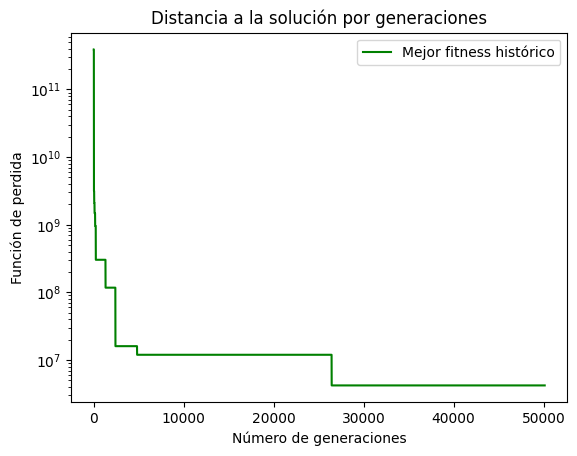

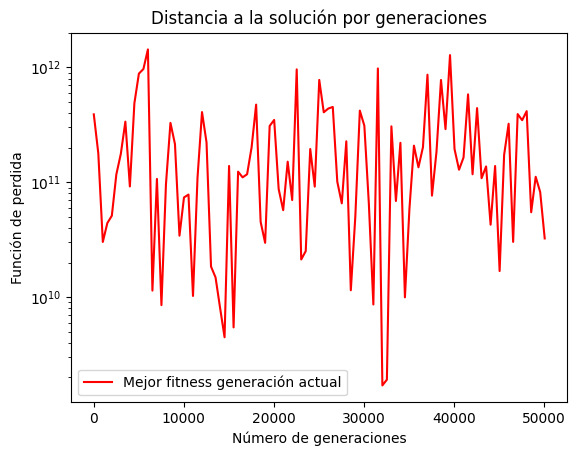

In [ ]:
p1 = generateProblem(50,2,500000000)
a1 = GeneticBaseAlgorithm(10000,0.1,initializeRandomPop,newGenerationMitosis)
a1.solve(p1)
print(a1.bestfitness_by_generations[-1])
a1.plotFitnessByGeneration(True, False)
a1.plotFitnessByGeneration(False, True)

In [ ]:
class LocalRandomSearchAlgorithm:
  def __init__(self):
    self.name = "Algoritmo Búqueda Local Aleatoria"

  def solve(self, problem):
    sol_length = len(problem.v_sack)
    while problem.max_evals - problem.n_evals > sol_length + 1:
      sol = [random.randint(0,1) for i in range(sol_length)]
      distance,sign_of_distance = problem.evaluation(sol)
      localSearch(sol,problem,distance,sign_of_distance)
      if problem.best_fitness == 0:
        break


def localSearch(individual,problem,distance = None,sign_of_distance = None):
  if distance == None or sign_of_distance == None:
    distance,sign_of_distance = problem.evaluation(individual)
  ind_lenght = len(individual)
  best_distance =  distance
  best_individual = individual
  for i in range(ind_lenght):
    new_individual = individual
    #print(new_individual[i])
    #print(sign_of_distance)
    if True or (int(new_individual[i]) == 0 and int(sign_of_distance) == 1) or (int(new_individual[i]) == 1 and int(sign_of_distance) == -1):
    #if (new_individual[i] == 1 and sign_of_distance == 1) or (new_individual[i] == 0 and sign_of_distance == -1):
      new_individual[i] = (individual[i]+1)%2
      new_distance,_ = problem.evaluation(new_individual)
      if new_distance < best_distance:
        best_individual = new_individual
        best_distance = new_distance
  return [best_individual,best_distance]

class MemeticAlgorithmBase:
  def __init__(self,maxpop,mutationrate,initializePop,newGeneration):
    self.maxpop = maxpop
    self.mutationrate = mutationrate
    self.initializePop = initializePop
    self.newGeneration = newGeneration
    self.name = "Algoritmo Memético"
    self.bestfitness_by_generations = []
    self.meanfitness_by_generations = []
    self.bestactualfitness_by_generations = []

  def solve(self, problem):
    problem_lenght = len(problem.v_sack)
    pop = self.initializePop(self.maxpop,problem_lenght)

    pop_distance = []
    for i in range(len(pop)):
      distance,_ = problem.evaluation(pop[i])
      pop_distance.append(distance)

    while problem.max_evals - problem.n_evals > self.maxpop//2*(problem_lenght+1)+self.maxpop:
      pop,pop_distance = self.newGeneration(problem,pop,pop_distance,self.maxpop,problem_lenght,self.mutationrate)
      if problem.best_fitness == 0:
              break

def newGenerationMemeticMitosis(problem, pop,pop_distance,maxpop,pop_lenght,mutationrate):
  new_pop_distace = []
  half_pop_lenght = pop_lenght//2
  half_maxpop = maxpop//2
  known_distances = []
  ordered_pop,oldindices = orderPop(pop,pop_distance)
  ordered_pop = ordered_pop[:half_maxpop]
  first_half_pop = ordered_pop[:,:half_pop_lenght]
  second_half_pop = ordered_pop[:,half_pop_lenght:]
  new_half_pop = np.hstack((first_half_pop,second_half_pop[range(half_maxpop-1,-1,-1),:]))
  for i in range(half_maxpop):
    new_pop_distace.append(pop_distance[oldindices[i]])

  for i in range(len(new_half_pop)):
    new_half_pop[i],new_distance = localSearch(new_half_pop[i],problem)
    new_pop_distace.append(new_distance)

  new_pop = np.vstack((ordered_pop,new_half_pop))

  while(len(new_pop) < maxpop):
    new_pop = np.vstack((new_pop,initializeRandomIndividual(pop_lenght)))
    new_distance = problem.evaluation(new_pop[-1])
    new_pop_distace.append(new_distance)

  new_pop,pop_distance = mutatePopMemetic(problem,new_pop,mutationrate,pop_distance)
  return [new_pop,new_pop_distace]


def mutatePopMemetic(problem,pop,mutationrate,pop_distance):
  x = 0
  maxpop = len(pop)
  while x < maxpop:
    if random.random() > (1-mutationrate)**len(pop[x]):
      y = random.randint(0,len(pop[x])-1)
      if pop[x,y] == 1:
        pop[x,y] = 0
      else:
        pop[x,y] = 1
      pop_distance[x] = problem.evaluation(pop[x])
    x += 1
  return [pop,pop_distance]

## Probar algoritmos

In [ ]:
def compareAlgorithm(list_algorithm,colors,n_problems,len_vector,initial_range,max_evals):
  evaluations_each_algorithm = []
  time_each_algorithm = []
  problems_resolved_each_algorithm = []
  n_alg = len(list_algorithm)
  for i in range(n_alg):
     evaluations_each_algorithm.append([])
     time_each_algorithm.append(0)
     problems_resolved_each_algorithm.append(0)
  for i in range(n_problems):
    problem = generateProblem(len_vector,initial_range,max_evals)
    for x,alg in enumerate(list_algorithm):
      act_problem = problem.create_new_try_clone()
      start_time = time.time()
      alg.solve(act_problem)
      end_time = time.time()
      evaluations_each_algorithm[x].append(act_problem.n_evals)
      time_each_algorithm[x] += end_time-start_time
      if(act_problem.best_fitness == 0):
        problems_resolved_each_algorithm[x] +=1

  problems_range = np.arange(0,n_problems)
  for i in range(n_alg):
    plt.plot(problems_range,evaluations_each_algorithm[i],colors[i])
    print("In ",time_each_algorithm[i]," seconds ",problems_resolved_each_algorithm[i]," problems have been solved by ",list_algorithm[i].name,i)
    #print("The algoritm ",list_algorithm[i].name,i," has taken ",time_each_algorithm[i]," seconds and have solved ",problems_resolved_each_algorithm[i]," problems")
  plt.show()

In [ ]:
def compareAlgorithmByFitness(list_algorithm,colors,n_problems,len_vector,initial_range,max_evals):
  final_fitness_each_algorithm = []
  time_each_algorithm = []
  problems_resolved_each_algorithm = []
  n_alg = len(list_algorithm)
  for i in range(n_alg):
     final_fitness_each_algorithm.append([])
     time_each_algorithm.append(0)
     problems_resolved_each_algorithm.append(0)
  for i in range(n_problems):
    problem = generateProblem(len_vector,initial_range,max_evals)
    for x,alg in enumerate(list_algorithm):
      act_problem = problem.create_new_try_clone()
      start_time = time.time()
      alg.solve(act_problem)
      end_time = time.time()
      final_fitness_each_algorithm[x].append(act_problem.best_fitness)
      time_each_algorithm[x] += end_time-start_time
      if(act_problem.best_fitness == 0):
        problems_resolved_each_algorithm[x] +=1

  problems_range = np.arange(0,n_problems)
  for i in range(n_alg):
    plt.plot(problems_range,final_fitness_each_algorithm[i],colors[i])
    print("In ",time_each_algorithm[i]," seconds ",problems_resolved_each_algorithm[i]," problems have been solved by ",list_algorithm[i].name,i)
    #print("The algoritm ",list_algorithm[i].name,i," has taken ",time_each_algorithm[i]," seconds and have solved ",problems_resolved_each_algorithm[i]," problems")
  plt.show()

In  3.4696877002716064  seconds  8  problems have been solved by  Genetic algorithm 0
In  4.743974685668945  seconds  10  problems have been solved by  Genetic algorithm 1
In  1.2202353477478027  seconds  7  problems have been solved by  Memetic algorithm 2
In  1.4372584819793701  seconds  8  problems have been solved by  Local Random search algorithm 3
In  0.16440701484680176  seconds  10  problems have been solved by  Exhaustive algorithm 4


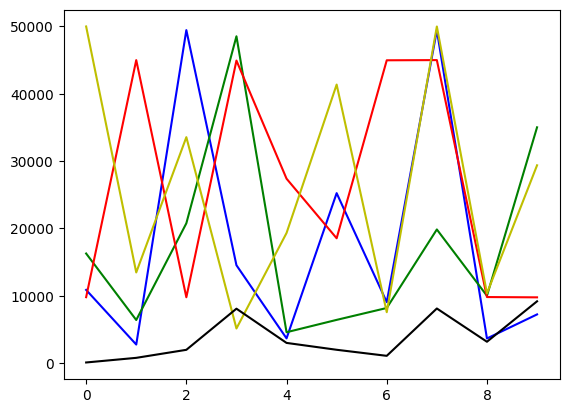

In [ ]:
#GeneticBaseAlgorithm(maxpop,mutationrate,initializePop,newGeneration)
#GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationTourney)
random.seed(2)
compareAlgorithm([GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationMitosis),
                  GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationTourney),
                  MemeticAlgorithmBase(1000,0.1,initializeRandomPop,newGenerationMemeticMitosis),
                  LocalRandomSearchAlgorithm(),
                  ExhaustiveAlgorithm()],['b','g','r','y','k'],10,100,2**1,50000)

In  1.3952691555023193  seconds  0  problems have been solved by  Genetic algorithm 0
In  2.7337567806243896  seconds  0  problems have been solved by  Genetic algorithm 1
In  0.50408935546875  seconds  0  problems have been solved by  Memetic algorithm 2
In  0.5925769805908203  seconds  0  problems have been solved by  Local Random search algorithm 3
In  0.5420231819152832  seconds  0  problems have been solved by  Exhaustive algorithm 4


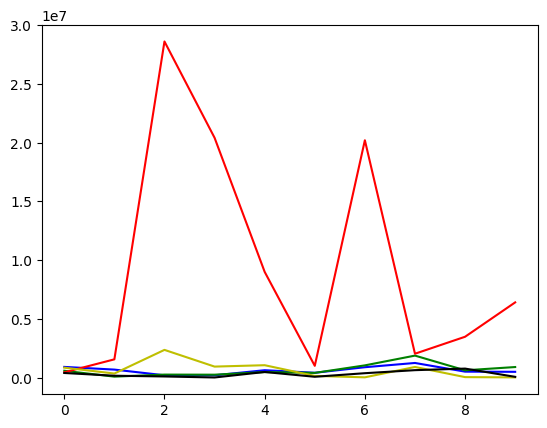

In [ ]:
random.seed(3)
compareAlgorithmByFitness([GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationMitosis),
                  GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationTourney),
                  MemeticAlgorithmBase(1000,0.1,initializeRandomPop,newGenerationMemeticMitosis),
                  LocalRandomSearchAlgorithm(),
                  ExhaustiveAlgorithm()],['b','g','r','y','k'],10,30,2**1,5000)

In [ ]:
def compareAlgorithmByTime(list_algorithm,colors,n_problems,list_len_vector,initial_range,max_evals):
  evaluations_each_algorithm = []
  time_each_algorithm = []
  problems_resolved_each_algorithm = []
  n_alg = len(list_algorithm)
  for i in range(n_alg):
    evaluations_each_algorithm.append([])
    time_each_algorithm.append([])
    problems_resolved_each_algorithm.append([])
    for k in range(len(list_len_vector)):
     evaluations_each_algorithm[i].append([])
     time_each_algorithm[i].append(0)
     problems_resolved_each_algorithm[i].append(0)

  for k,len_vector in enumerate(list_len_vector):
    for i in range(n_problems):
      problem = generateProblem(len_vector,initial_range,max_evals)
      for x,alg in enumerate(list_algorithm):
        act_problem = problem.create_new_try_clone()
        start_time = time.time()
        alg.solve(act_problem)
        end_time = time.time()
        evaluations_each_algorithm[x][k].append(act_problem.n_evals)
        time_each_algorithm[x][k] += end_time-start_time
        if(act_problem.best_fitness == 0):
          problems_resolved_each_algorithm[x][k] +=1

  for i in range(n_alg):
    evals = []
    for k in range(len(list_len_vector)):
      evals.append(sum(evaluations_each_algorithm[i][k]))
    evaluations_each_algorithm[i] = evals

  print(evaluations_each_algorithm)
  print(time_each_algorithm)
  print(problems_resolved_each_algorithm)



  len_range = np.arange(0,len(list_len_vector))
  for i in range(n_alg):
    plt.plot(list_len_vector,time_each_algorithm[i],colors[i])
    print("In ",sum(time_each_algorithm[i])," seconds ",sum(problems_resolved_each_algorithm[i])," problems have been solved by ",list_algorithm[i].name,i)
    #print("The algoritm ",list_algorithm[i].name,i," has taken ",time_each_algorithm[i]," seconds and have solved ",problems_resolved_each_algorithm[i]," problems")


  plt.xlabel('Longitud del problema')
  plt.ylabel('Tiempo(s)')

  plt.title("Problema de la suma de subconjuntos")
  plt.legend(list(list_algorithm[i].name for i in range(n_alg)), loc = "upper left")

  plt.show()

[[3813, 8180, 38471, 162763, 1216601], [21459, 39043, 36074, 105460, 768948], [3212, 20748, 102540, 66793, 1167512], [353, 5635, 14061, 32327, 124488]]
[[0.06028485298156738, 0.15343904495239258, 0.7430806159973145, 2.8411664962768555, 22.584444284439087], [0.10889983177185059, 0.19246578216552734, 0.16656994819641113, 0.4474062919616699, 3.193944215774536], [0.013655662536621094, 0.11127114295959473, 0.500194787979126, 0.32817769050598145, 6.030943393707275], [0.0012722015380859375, 0.021877527236938477, 0.055283308029174805, 0.13923907279968262, 0.5677773952484131]]
[[3, 3, 3, 3, 2], [3, 3, 3, 3, 3], [3, 3, 3, 3, 2], [3, 3, 3, 3, 3]]
In  26.382415294647217  seconds  14  problems have been solved by  Algoritmo Genético 0
In  4.109286069869995  seconds  15  problems have been solved by  Algoritmo Memético 1
In  6.984242677688599  seconds  14  problems have been solved by  Algoritmo Búqueda Local Aleatoria 2
In  0.7854495048522949  seconds  15  problems have been solved by  Algoritmo Ex

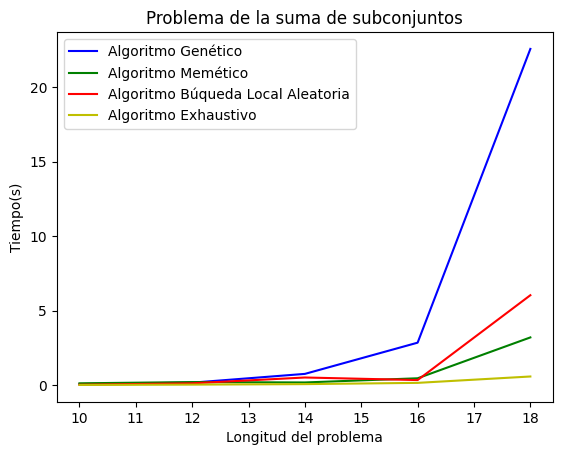

In [ ]:
#,12,13,14,15,16,17
#GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationTourney),
random.seed(2)
compareAlgorithmByTime([GeneticBaseAlgorithm(1000,0.1,initializeRandomPop,newGenerationMitosis),
                  MemeticAlgorithmBase(1000,0.1,initializeRandomPop,newGenerationMemeticMitosis),
                  LocalRandomSearchAlgorithm(),
                  ExhaustiveAlgorithm()],['b','g','r','y','k'],3,[10,12,14,16,18],2**1,1000000)

## Fitness by generation

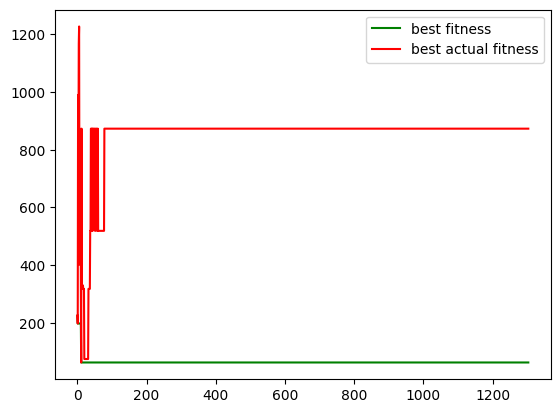

In [ ]:
problem1 = generateProblem(15,2**1,100000)
alg1 = GeneticBaseAlgorithm(100,0.05,initializeRandomPop,newGenerationMitosis)
alg1.solve(problem1)
alg1.plotFitnessByGeneration()

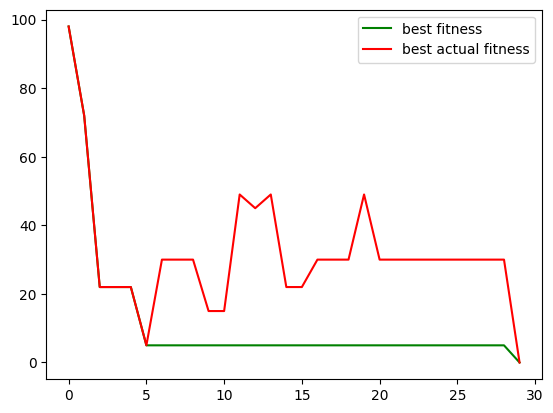

In [ ]:
#newGenerationTourney(pop,pop_distance,maxpop,pop_lenght,mutationrate)
problem1 = generateProblem(10,2**1,100000)
alg1 = GeneticBaseAlgorithm(100,0.05,initializeRandomPop,newGenerationTourney)
alg1.solve(problem1)
alg1.plotFitnessByGeneration()

## Función de loss

In [ ]:
def trylossfunction(n_problems,len_vector,initial_range):

  mean_fitness_vector = []
  for p in range(n_problems):
    mean_fitness_per_batch = []
    [public_key,private_key] = generateCriptoSistem(len_vector,initial_range)
    obj_sol = np.array([random.randint(0,1) for i in range(len_vector)])
    obj_sum = np.dot(obj_sol,public_key)
    problem = Problem(public_key,obj_sum,2**(len_vector+100))
    for i in range(1,len_vector):
      actual_fitness = []
      for x in range(100):
        pos = random.choices(range(len_vector),k=i)
        actual_sol = obj_sol
        for y in pos:
          actual_sol[y] = (actual_sol[y] + 1) % 2
        actualeval,_ = problem.evaluation(actual_sol)
        actual_fitness.append(actualeval)
      #print(actual_fitness)
      mean_fitness_per_batch.append(sum(actual_fitness)/len(actual_fitness))
    mean_fitness_vector.append(mean_fitness_per_batch)

  final_vector = []
  for x in range(len_vector-1):
    actualsum = 0
    for y in range(n_problems):
      actualsum += mean_fitness_vector[y][x]
    final_vector.append(actualsum/n_problems)

  plt.plot(final_vector)
  plt.xlabel('Distancia de Hamming')
  plt.ylabel('Función objetivo')

  plt.title("Comparación de la función de perdida")

  plt.show()

In [ ]:
random.choices(range(10),k=2)

[5, 2]

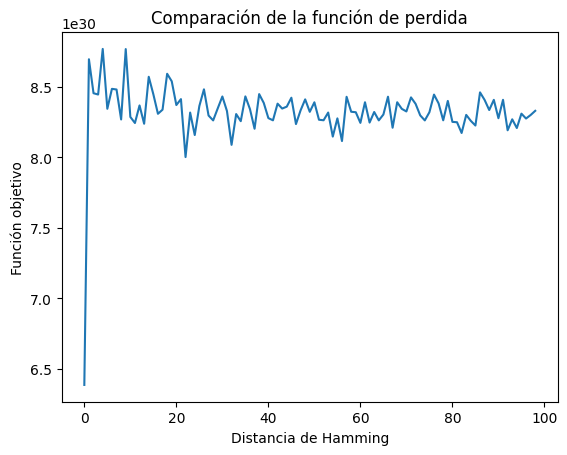

In [ ]:
trylossfunction(50,100,2**1)